In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from generateData import *
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [49]:
#torch.set_default_tensor_type(torch.DoubleTensor)

In [50]:
class Network(nn.Module):
    #This network performs one time step integration for the splitting into 3 vector fields
    def __init__(self, in_chan, mLiftV, lV, mLiftF, lF):
        super(Network, self).__init__()

        self.input = in_chan
        self.mLiftV = mLiftV
        self.mLiftF = mLiftF

        self.layersV = lV
        self.layersF = lF

        self.out = int(in_chan * (in_chan-1) / 2)
        
        Vlist = []
        Flist = []

        self.A = nn.Parameter(torch.randn(self.input,self.input))

        Vlist.append(nn.Linear(self.input,self.mLiftV))
        for i in range(self.layersV):
            Vlist.append(nn.Sigmoid())
            if i==self.layersV-1:
                Vlist.append(nn.Linear(self.mLiftV,1))
            else:
                Vlist.append(nn.Linear(self.mLiftV,self.mLiftV))
        self.V = nn.Sequential(*Vlist)
            
        Flist.append(nn.Linear(self.input,self.mLiftF))
        for i in range(self.layersF):
            Flist.append(nn.Sigmoid())
            if i==self.layersF-1:
                Flist.append(nn.Linear(self.mLiftF,self.out))
            else:
                Flist.append(nn.Linear(self.mLiftF,self.mLiftF))
        self.F = nn.Sequential(*Flist)
    
    def buildSkew(self,ff):
        res = torch.zeros((len(ff),self.input,self.input))
        iu1 = torch.triu_indices(self.input,self.input,1)
        res[:,iu1[0],iu1[1]] = ff
        res = res - torch.transpose(res,1,2)
        return res

    def sphVF(self, x):
        ff = self.F(x)
        mat = self.buildSkew(ff)
        return torch.einsum('ijk,ik->ij',mat,x) #+ x @ (self.A-(self.A).T)

    def heunStep(self,func,h,y):
        yy = y + h*func(y)
        return y + h/2 * (func(y) + func(yy))

    def correction(self,func,h,y):
        phi = self.heunStep(func,h,y)
        return (torch.linalg.norm(phi,dim=1)**2 - torch.linalg.norm(y,dim=1)**2)/torch.linalg.norm(phi-y,dim=1)**2

    def step(self,h,y):
        l = self.correction(self.sphVF,h,y)
        return torch.einsum('i,ij->ij',1-l , self.heunStep(self.sphVF,h,y)) + torch.einsum('i,ij->ij',l , y)

    def gradField(self,x):
        y = x.detach().clone().to(x.device).requires_grad_()
        ff = self.V(y).sum()
        return torch.autograd.grad(ff,y)[0]
        
    def GonzalezDG(self,x,y):
        gHalf = self.gradField(0.5*(x+y))
        return gHalf + (self.V(y)-self.V(x)-torch.einsum('ij,ij->i',gHalf,y-x).unsqueeze(1)) / (torch.linalg.norm(x-y,ord=2,dim=1)**2).unsqueeze(1) * (y-x)

In [51]:
N = 1000
dim = 4
B = np.random.rand(dim,dim)
A = B-B.T
f = lambda t,x: np.sin(x)**3 + x**3
#f = lambda t,x: np.sin(x)

In [52]:
h = 0.05
Ntrain = 0.9
noisy = False
M = 2
T = h
x_train, y_train, x_test, y_test, h = generate(N,M,T,dim,f,Ntrain,noisy)

0.05


In [53]:
batch_size = 64

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx] 
  def __len__(self):
    return self.length 

trainset = dataset(x_train,y_train)
testset = dataset(x_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [54]:
lV = 2
lF = 3
net = Network(dim,10,lV,60,lF)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)#, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [55]:
def train(model, steps, dt, criterion, optimizer, scheduler, trainloader, epochs=100):
    
    for epoch in range(epochs):
        losses = []
        running_loss = 0
        for i, inp in enumerate(trainloader):
            inputs, labels = inp
            inputs = inputs.requires_grad_()
            optimizer.zero_grad()
            loss = 0
            for l in range(steps):
                supp = model.step(dt,inputs)
                #updated = inputs + dt * (model.sphVF(inputs) + model.gradField(inputs))
                updated = supp + dt * model.GonzalezDG(supp,labels[:,:,l])
                #updated = supp + dt * model.gradField(supp)
                #updated = inputs + dt * model.F(inputs)
                loss += criterion(updated,labels[:,:,l])
            losses.append(loss.item())
            loss.backward()

            optimizer.step()
            
            running_loss += loss.item()
            
            if i%(max(10,epochs//100)) == 0 and i > 0:
                print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
                running_loss = 0.0
        
        scheduler.step()
    print('Training Done')
    return loss

In [56]:
train(net, M-1, h, criterion, optimizer, scheduler, trainloader, epochs=200)

Loss [1, 10](epoch, minibatch):  0.00031158662983216346
Loss [2, 10](epoch, minibatch):  0.0001428458432201296
Loss [3, 10](epoch, minibatch):  0.00015969825093634427
Loss [4, 10](epoch, minibatch):  0.00014334703213535248
Loss [5, 10](epoch, minibatch):  0.00011479156091809273
Loss [6, 10](epoch, minibatch):  9.399015805684031e-05
Loss [7, 10](epoch, minibatch):  8.092343632597477e-05
Loss [8, 10](epoch, minibatch):  5.4326517274603245e-05
Loss [9, 10](epoch, minibatch):  3.7045171484351155e-05
Loss [10, 10](epoch, minibatch):  3.788823785725981e-05
Loss [11, 10](epoch, minibatch):  3.097605527727865e-05
Loss [12, 10](epoch, minibatch):  2.7279752539470793e-05
Loss [13, 10](epoch, minibatch):  2.7555147971725093e-05
Loss [14, 10](epoch, minibatch):  2.8323135775281117e-05
Loss [15, 10](epoch, minibatch):  2.7089903451269492e-05
Loss [16, 10](epoch, minibatch):  2.557697822339833e-05
Loss [17, 10](epoch, minibatch):  2.5434561830479652e-05
Loss [18, 10](epoch, minibatch):  2.5337137631

tensor(2.7536e-05, grad_fn=<AddBackward0>)

In [57]:
net.eval();

In [58]:
def approxVecField(t,x):
    y = torch.from_numpy(x.astype(np.float32)).unsqueeze(0)
    vec = net.sphVF(y)[0] + net.gradField(y)[0]
    #vec = net.F(y)[0]
    #vec = net.F(y)[0] + net.gradField(y)[0]
    return vec.detach().cpu().numpy()

In [59]:
Mtest = 20
Ttest = 0.1
timeTest = np.linspace(0,Ttest,Mtest)
y_pred = np.zeros([len(x_test),dim,Mtest])
y_true = np.zeros([len(x_test),dim,Mtest])
for i in range(len(x_test)):
    y_pred[i,:,:] = scipy.integrate.solve_ivp(approxVecField,[0, Ttest],x_test[i,:],method='RK45',t_eval=timeTest,rtol=1e-5,atol=1e-6).y
    y_true[i,:,:] = scipy.integrate.solve_ivp(f,[0, Ttest],x_test[i,:],method='RK45',t_eval=timeTest,rtol=1e-5,atol=1e-6).y

(-1.0, 1.0)

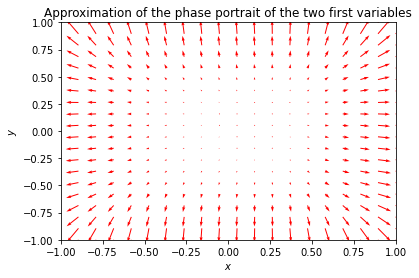

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def vecField(Y, t):
    #approxVecField
    y1, y2 = Y
    yy = np.zeros((dim))
    yy[0] = y1
    yy[1] = y2
    return approxVecField(t,yy)

y1 = np.linspace(-1, 1, 20)
y2 = np.linspace(-1, 1, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape

for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = vecField([x, y], t)
        u[i,j] = yprime[0]
        v[i,j] = yprime[1]
     
Q = plt.quiver(Y1, Y2, u, v, color='r')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Approximation of the phase portrait of the two first variables")
plt.xlim([-1, 1])
plt.ylim([-1, 1])

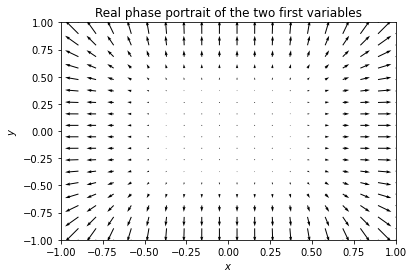

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def realVecField(Y, t):

    #approxVecField

    y1, y2 = Y
    yy = np.zeros((dim))
    yy[0] = y1
    yy[1] = y2
    return f(t,yy)

y1 = np.linspace(-1, 1, 20)
y2 = np.linspace(-1, 1, 20)
Y11, Y21 = np.meshgrid(y1, y2)
t = 0
u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape

for i in range(NI):
    for j in range(NJ):
        x = Y11[i, j]
        y = Y21[i, j]
        yprime = realVecField([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
     
Q = plt.quiver(Y11, Y21, u1, v1, color='k')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Real phase portrait of the two first variables")
plt.xlim([-1, 1])
plt.ylim([-1, 1]);

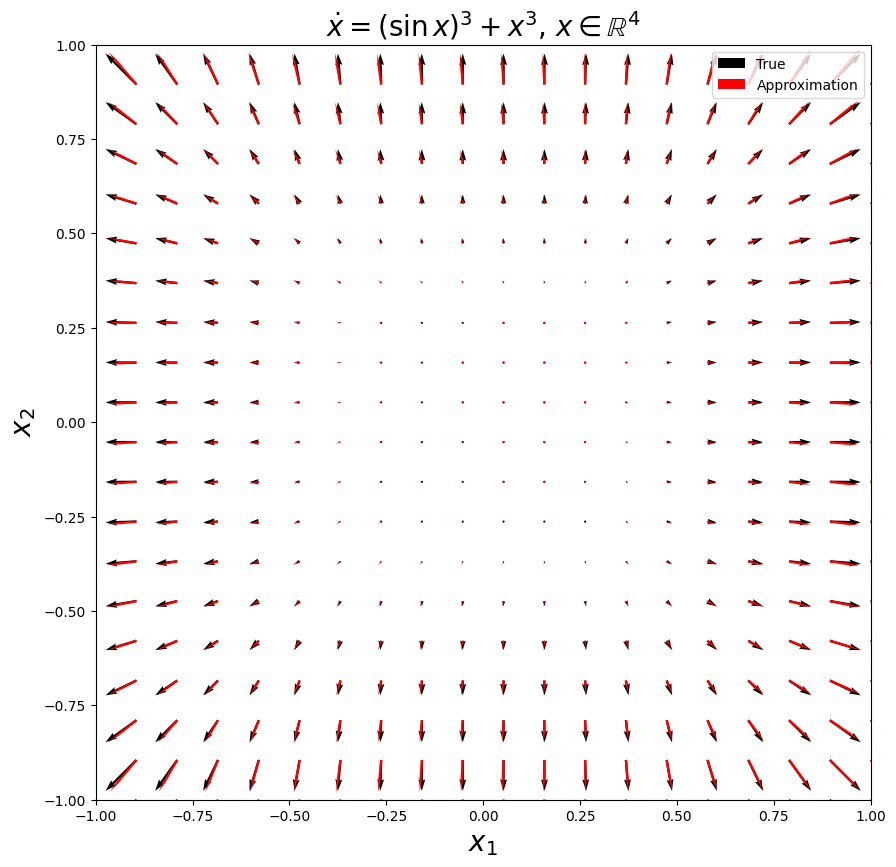

In [63]:
plt.figure(figsize=(10,10),dpi=100)

Q = plt.quiver(Y11, Y21, u1, v1, color='k',label="True")
R = plt.quiver(Y1, Y2, u, v, color='r',headwidth=1,label="Approximation")

plt.xlabel(r'$x_1$',fontsize=20)
plt.ylabel(r'$x_2$',fontsize=20)
'''plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$p$',fontsize=20)'''
plt.title(r"$\dot{x}=(\sin{x})^3+x^3$, $x\in\mathbb{R}^4$",fontsize=20)
#lt.title(r"$\dot{x} = p$, $\dot{p}=-\sin{x}$",fontsize=20)
plt.legend()
plt.xlim([-1, 1])
plt.ylim([-1, 1]);